# Descriptive trends

The landscape for taxis have changed drastically, particularly with the introduction of Uber in 2009.
In this notebook, we consider different trends - such as:
1. Do different periods (months) lend to higher traffic in NYC taxis?
2. Can we see a fall in taxi rides post 2009? How have taxis fared since Ubers?
3. At what different *times* of the day are taxis busiest?

These questions will have us create a pricing model.

In [2]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

### What months are taxis the busiest?

In [3]:
year_data_dict = defaultdict(list)

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_ptr_dt = pd.to_datetime(date_ptr)
    year = date_ptr_dt.year
    month = date_ptr_dt.strftime('%B')
    
    date_data = pd.read_parquet(f'../data/clean_data_adjusted_geo/{date_ptr}.parquet')
    year_data_dict[year].append({
        'month': date_ptr_dt,
        'fare_sum': date_data['fare_amount'].sum()
    })
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

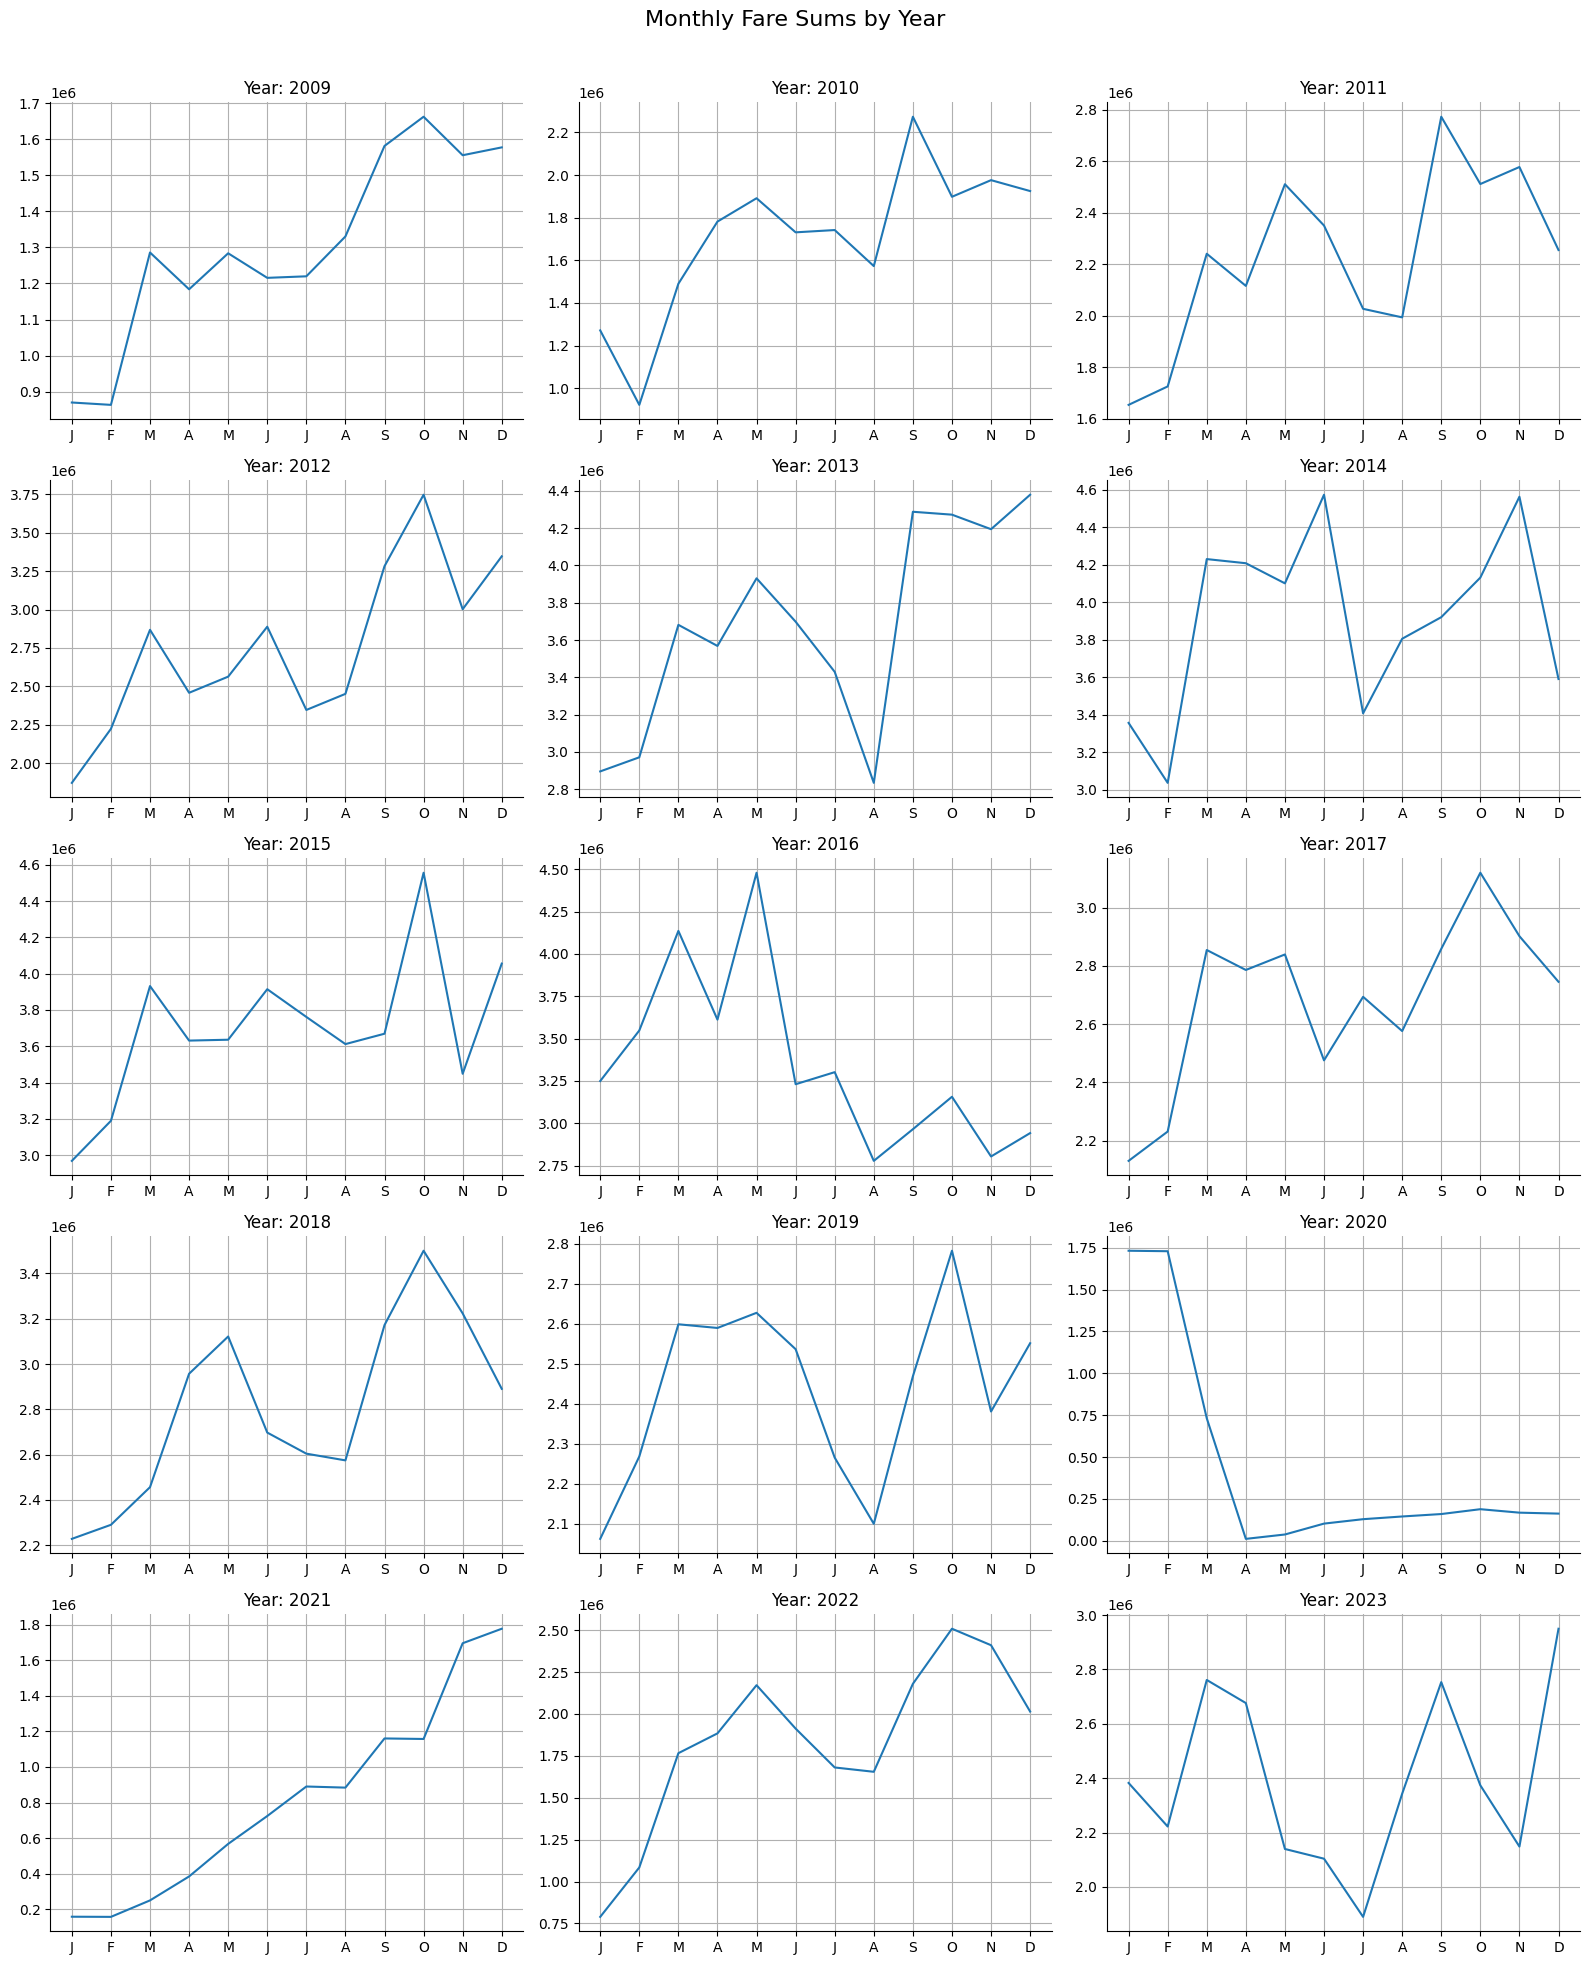

In [25]:
n_years = len(year_data_dict)
n_cols = 3
n_rows = -(-n_years // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=False)
axes = axes.flatten()

for idx, (k, v) in enumerate(sorted(year_data_dict.items())):
    year_df = pd.DataFrame(v)
    ax = axes[idx]
    
    # Extract numeric and abbreviated month
    year_df['month_num'] = pd.to_datetime(year_df['month']).dt.month
    month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

    ax.plot(year_df['month_num'], year_df['fare_sum'])
    ax.set_title(f"Year: {k}")
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels)
    ax.grid()
    sns.despine()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Monthly Fare Sums by Year", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

We see general peaks around April-May, and then again during September-October. How have fares generally trended across the years?

### How have taxis been affected by Uber?

Uber was introduced post 2009

In [6]:
all_data = []

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/clean_data_adjusted_geo/{date_ptr}.parquet')
    all_data.append({
        'date_ptr': pd.to_datetime(date_ptr),
        'fare_amount_sum': date_data['fare_amount'].sum()
    })
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

all_data_df = pd.DataFrame(all_data)

Text(0.5, 1.0, 'Monthly taxi fares from 2009 to 2024')

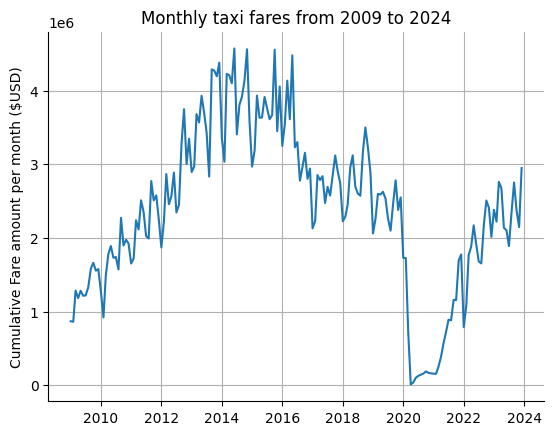

In [37]:
plt.plot(all_data_df['date_ptr'], all_data_df['fare_amount_sum'])
sns.despine()
plt.ylabel('Cumulative Fare amount per month ($USD)')
plt.grid()
plt.title('Monthly taxi fares from 2009 to 2024')

It appears Uber took some market share post 2016 - then the COVID-19 pandemic hits; post 2022, taxi fares seem to have recovered to pre-COVID levels.

### Which days of the week are busiest?

In [3]:
concat_data = []

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    concat_data.append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

all_data_df = pd.concat(concat_data)

In [7]:
all_data_df['hour'] = all_data_df['pickup_datetime'].dt.hour
hour_counts = all_data_df.groupby('hour')['fare_amount'].count()

In [27]:
day_hours_data = {}
for day, data in all_data_df.groupby('day'):
    day_hours_data[day] = data.groupby('hour')['fare_amount'].count()

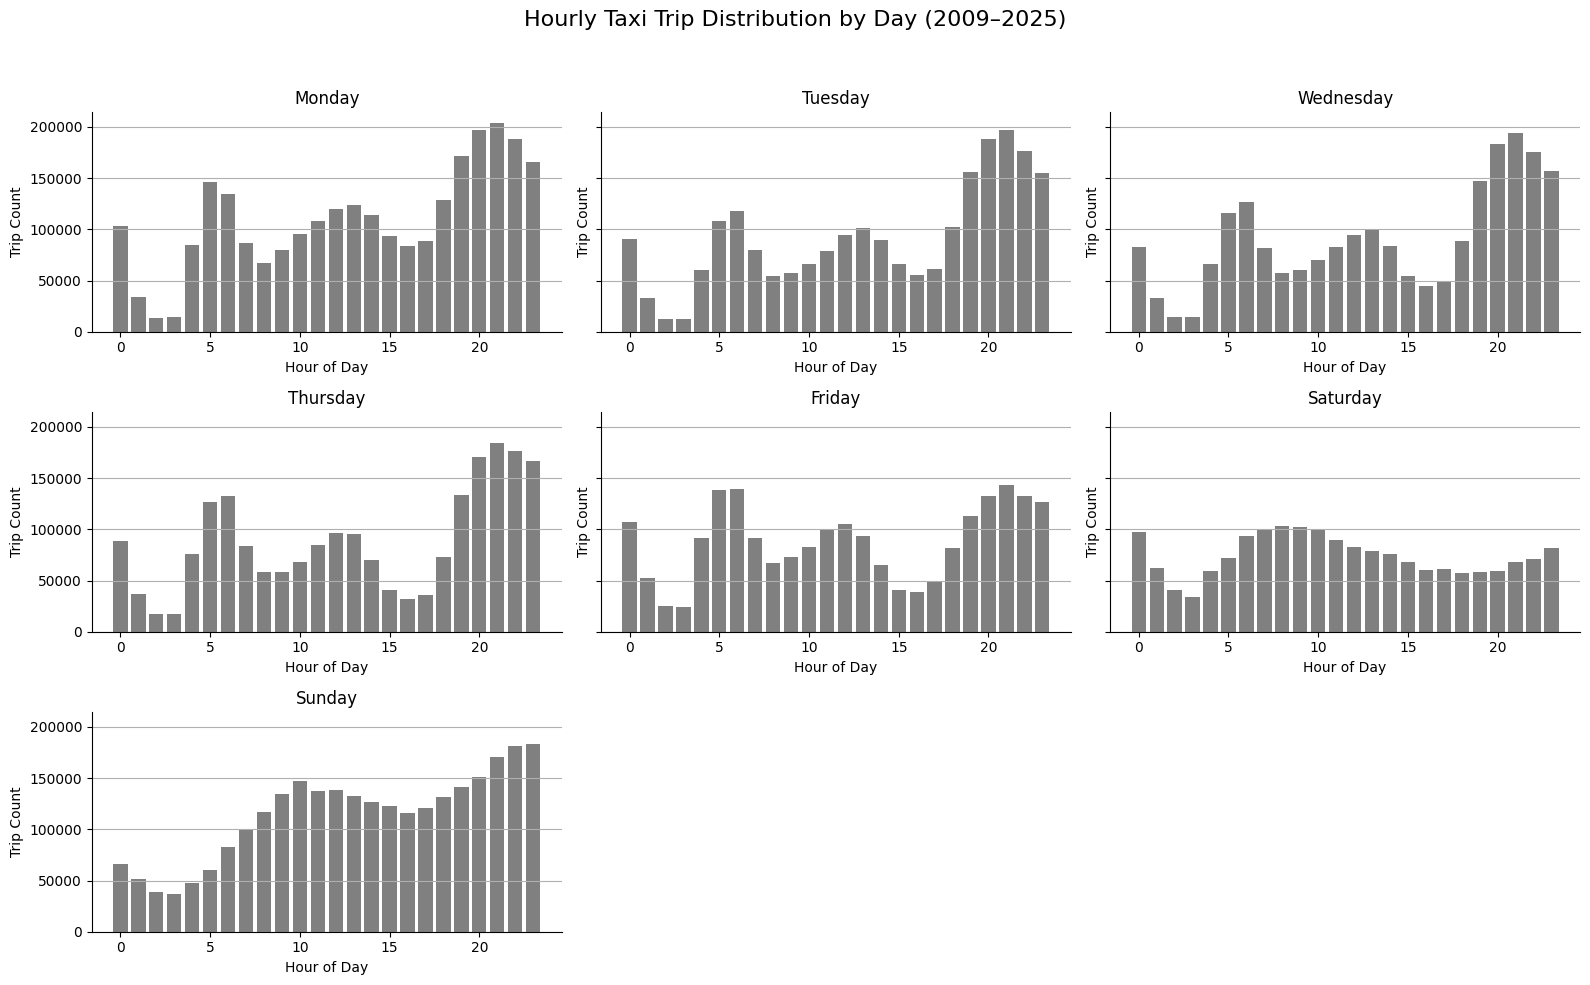

In [32]:
import calendar

# Sort the data by weekday
ordered_days = list(calendar.day_name)
day_hours_data_sorted = {day: day_hours_data[day] for day in ordered_days if day in day_hours_data}

num_days = len(day_hours_data_sorted)
cols = 3
rows = (num_days + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for i, (day, counts) in enumerate(day_hours_data_sorted.items()):
    ax = axes[i]
    ax.bar(counts.index, counts, color='grey')
    ax.set_title(f'{day}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Trip Count')
    ax.grid(axis='y')
    sns.despine(ax=ax)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Hourly Taxi Trip Distribution by Day (2009–2025)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

As we can see above, weekdays and weekends behave distinctly different - Saturday is clearly less busy, whereas Sunday picks up. But both have a similar curve. We can model multipliers relative to surge using these curves - which can be updated live.